In [1]:
import sys
import os
sys.path.append('../')

In [2]:
import torch
import faiss
from PIL import Image
from tqdm import tqdm
import torchvision.transforms as T
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timm

from utils.data import get_loaders
from utils.metrics import mean_average_precision_at_k
from utils.constants import TRAIN_CSV, TEST_CSV, TRAIN_DIR, TEST_DIR

c:\Users\Andrii\miniconda3\envs\image_retrieval\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# image_processor = AutoImageProcessor.from_pretrained("facebook/dinov2-base")
# model = Dinov2Model.from_pretrained("facebook/dinov2-base").to("cuda")

In [4]:
TRAIN_CSV

'c:\\Users\\Andrii\\Data\\_UNIVER\\UCU\\3 sem\\CV\\image_retrieval\\data\\train.csv'

In [5]:
loaders_params = { 
    'batch_size': 64,
    'num_workers': 8,
    'pin_memory': False,
    'persistent_workers': True,
}
train_loader, val_loader, test_loader = get_loaders(**loaders_params,
                                                    train_transforms=T.Compose([
                                                        T.Resize(224, interpolation=T.InterpolationMode.BICUBIC),
                                                        T.CenterCrop((224, 224)),
                                                        T.ToTensor(),
                                                        T.Normalize(mean=torch.tensor([0.4815, 0.4578, 0.4082]),
                                                                    std=torch.tensor([0.2686, 0.2613, 0.2758])),
                                                    ]),
                                                    test_transforms=T.Compose([
                                                        T.Resize(224, interpolation=T.InterpolationMode.BICUBIC),
                                                        T.CenterCrop((224, 224)),
                                                        T.ToTensor(),
                                                        T.Normalize(mean=torch.tensor([0.4815, 0.4578, 0.4082]),
                                                                    std=torch.tensor([0.2686, 0.2613, 0.2758])),
                                                    ]))

In [6]:
# inputs = image_processor(image_torch, return_tensors="pt")
# inputs = {k: v.to("cuda") for k, v in inputs.items()}

In [7]:
# with torch.no_grad():
#     outputs = model(**inputs)

In [8]:
# embeddings = outputs.pooler_output.cpu()

In [9]:
# embeddings.shape

In [10]:
model = timm.create_model('vit_huge_patch14_clip_224.laion2b_ft_in12k_in1k', 
                          pretrained=True,
                          features_only=True,
                          in_chans=3).to('cuda')

In [11]:
class ImageEmbedding(torch.nn.Module):
    def __init__(self, model):
        super().__init__()
        self.model = model
        self.model.eval()
        self.avgpool = torch.nn.AdaptiveAvgPool2d((1, 1))
    
    def __call__(self, images):
        with torch.no_grad():
            outputs = self.model(images)[-1]
        embeddings = self.avgpool(outputs).squeeze(dim=(2, 3))
        return embeddings

In [12]:
model = ImageEmbedding(model)

In [13]:
index = faiss.IndexFlatL2(1280)

In [14]:
info_df = pd.DataFrame(columns=["embedding", "label"])

In [15]:
model = model.to('cuda')

In [16]:
for images, labels in tqdm(train_loader):
    images = images.to('cuda')
    
    with torch.no_grad():
        outputs = model(images)

    embeddings = outputs.cpu().numpy()

    embeddings /= np.linalg.norm(embeddings, axis=1, ord=2, keepdims=True)

    index.add(embeddings)

    info_df = pd.concat([info_df, pd.DataFrame({"embedding": embeddings.tolist(), "label": labels.tolist()})]).reset_index(drop=True)

100%|██████████| 54/54 [03:12<00:00,  3.57s/it]


In [17]:
k = 4                          # we want to see 4 nearest neighbors
D, I = index.search(np.stack(info_df.iloc[:5, 0]), k) # sanity check
print(I)
print(D)

[[   0 2314  304 1181]
 [   1 2865  134 3066]
 [   2 2200  896    7]
 [   3 3241 2984 2213]
 [   4 1197 1496 1107]]
[[0.         0.00128143 0.00200144 0.01544471]
 [0.         0.01015058 0.01032665 0.0117109 ]
 [0.         0.02443112 0.02501391 0.02663725]
 [0.         0.01678016 0.01730005 0.01756703]
 [0.         0.01157962 0.01968325 0.03675397]]


In [21]:
info_df.iloc[I[1]]

,embedding,label
1475,"[0.005622134543955326, 0.004532663617283106, 0...",836
2120,"[0.007937784306704998, 0.0008269997197203338, ...",992
1917,"[0.007390028331428766, -0.001740914536640048, ...",810
1029,"[0.006732639390975237, 0.0004799966118298471, ...",982
2974,"[0.01100267842411995, 0.0006617089384235442, 0...",971
...,...,...
936,"[0.008517772890627384, 0.002008906565606594, 0...",372
640,"[0.012292384169995785, 0.0008968514739535749, ...",913
1743,"[0.006986198481172323, -6.0722744819941e-05, 0...",931
292,"[0.011624250560998917, 0.004361431114375591, 0...",943


In [19]:
all_labels = []
all_preds = []
all_class_lengths = []
for images, labels in tqdm(val_loader):
    images = images.to('cuda')
    
    with torch.no_grad():
        outputs = model(images)

    embeddings = outputs.cpu().numpy()

    embeddings /= np.linalg.norm(embeddings, axis=1, ord=2, keepdims=True)

    D, I = index.search(embeddings, 100)
    all_labels.append(labels.numpy())

    for i in range(len(images)):
        class_ids_top100 = info_df.iloc[I[i], 1].values
        place_values = np.array([0.95**i for i in range(100)])
        preds = np.zeros(1200) #np.ones(1200) * np.inf
        for j in reversed(range(100)):
            preds[class_ids_top100[j]] = place_values[j]
        
        all_preds.append(preds)
        try:
            label_pos = np.where(class_ids_top100 == labels[i].item())[0][0]
            all_class_lengths.append(D[i, label_pos])
        except:
            all_class_lengths.append(10000)
        # all_class_lengths.append(preds[labels[i].item()])
    

all_labels = np.concatenate(all_labels)
all_preds = np.stack(all_preds)

mean_average_precision_at_k(all_labels, all_preds, k=5)


100%|██████████| 3/3 [00:32<00:00, 10.76s/it]


0.6325

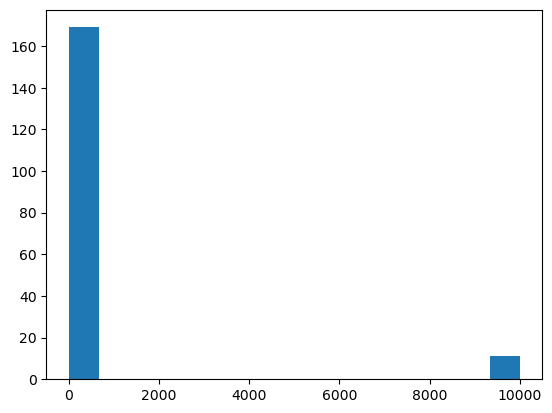

In [20]:
all_class_lengths = np.array(all_class_lengths)
plt.hist(all_class_lengths[all_class_lengths < 100000], bins=15)
plt.show()

- IP index, normalized: 0.6307
- L2 index, unnormalized: 0.6151
- L2 index, normalized: 0.6325

In [22]:
np.median(all_class_lengths)

0.01533740758895874

In [23]:
for images, labels in tqdm(val_loader):
    images = images.to('cuda')
    
    with torch.no_grad():
        outputs = model(images)

    embeddings = outputs.cpu().numpy()

    embeddings /= np.linalg.norm(embeddings, axis=1, ord=2, keepdims=True)

    index.add(embeddings)

    info_df = pd.concat([info_df, pd.DataFrame({"embedding": embeddings.tolist(), "label": labels.tolist()})]).reset_index(drop=True)

100%|██████████| 3/3 [00:09<00:00,  3.09s/it]


In [24]:
THRESHOLD = 0.02

In [25]:
test_preds = []
for images in tqdm(test_loader):
    images = images.to('cuda')
    
    with torch.no_grad():
        outputs = model(images)

    embeddings = outputs.cpu().numpy()

    embeddings /= np.linalg.norm(embeddings, axis=1, ord=2, keepdims=True)

    D, I = index.search(embeddings, 100)

    for i in range(len(images)):
        class_ids_top100 = info_df.iloc[I[i], 1].values
        preds = np.ones(1200) * np.inf
        # preds = np.zeros(1200)
        for j in reversed(range(100)):
            preds[class_ids_top100[j]] = D[i, j]
        
        top_classes = np.argsort(preds)[:5] # [::-1][:5]
        top_classes_dists = preds[top_classes]

        # set -1 on the first place after THRESHOLD
        cutoff_location = np.sum(preds < THRESHOLD)
        if cutoff_location < 5:
            for j in range(1, 5 - cutoff_location):
                top_classes[5 - j] = top_classes[5 - j - 1]
            top_classes[cutoff_location] = -1

        test_preds.append(top_classes)

100%|██████████| 205/205 [11:26<00:00,  3.35s/it]


In [26]:
test_df = pd.read_csv(TEST_CSV)

In [27]:
test_df['class'] = [' '.join([str(el) for el in classes]) for classes in test_preds]

In [28]:
test_df[['file_id', 'class']].to_csv('../submissions/vit_clip_l2_norm_thresh0.2.csv', index=False)

In [29]:
test_preds = []
for images in tqdm(test_loader):
    images = images.to('cuda')
    
    with torch.no_grad():
        outputs = model(images)

    embeddings = outputs.cpu().numpy()

    embeddings /= np.linalg.norm(embeddings, axis=1, ord=2, keepdims=True)

    D, I = index.search(embeddings, 100)

    for i in range(len(images)):
        class_ids_top100 = info_df.iloc[I[i], 1].values
        preds = np.ones(1200) * np.inf
        # preds = np.zeros(1200)
        for j in reversed(range(100)):
            preds[class_ids_top100[j]] = D[i, j]
        
        top_classes = np.argsort(preds)[:5] # [::-1][:5]
        top_classes_dists = preds[top_classes]

        test_preds.append(top_classes)

100%|██████████| 205/205 [11:04<00:00,  3.24s/it]


In [30]:
test_df['512x512'] = test_df['file_id'].apply(lambda file_id: (Image.open(os.path.join(TEST_DIR, f'{file_id}.jpg')).size) == (512, 512))

In [31]:
test_df['class'] = [[str(el) for el in classes] for classes in test_preds]

In [32]:
test_df.loc[test_df['512x512'], 'class'] = test_df.loc[test_df['512x512'], 'class'].apply(lambda classes: '-1 ' + ' '.join(classes[:-1]))
test_df.loc[~test_df['512x512'], 'class'] = test_df.loc[~test_df['512x512'], 'class'].apply(lambda classes: ' '.join(classes))

In [33]:
test_df[['file_id', 'class']].to_csv('../submissions/vit_clip_l2_norm_leak.csv', index=False)